# 并行

本节介绍两种实现并行的方法：

- 节点并行
- Map-reduce


In [1]:
import os
import time
import operator

from dotenv import load_dotenv
from typing import Annotated
from datetime import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Send

# 加载模型配置
_ = load_dotenv()

# 加载模型
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="qwen3-max",
    temperature=0.7,
)

## 一、节点并行

节点并行很容易实现，使用 `StateGraph` 创建带并行节点的工作流就可以。

下面是一个简单的节点并行的例子。你可以观察节点运行的时间戳，确认它们是否真的在并行。

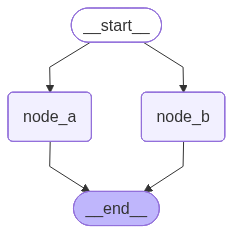

In [2]:
# 创建并行节点a
def node_a(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_a] 进入函数时间: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # 使用 sleep 模拟占用时间
    time.sleep(2)

    end_time = datetime.now()
    print(f"[node_a] 退出函数时间: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'节点a运行了{round((end_time - start_time).total_seconds(), 3)}秒'
    )]}

# 创建并行节点b
def node_b(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_b] 进入函数时间: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # 使用 sleep 模拟占用时间
    time.sleep(4)

    end_time = datetime.now()
    print(f"[node_b] 退出函数时间: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'节点b运行了{round((end_time - start_time).total_seconds(), 3)}秒'
    )]}

# 创建图
builder = StateGraph(MessagesState)

# 添加节点
builder.add_node('node_a', node_a)
builder.add_node('node_b', node_b)

# 添加边
builder.add_edge(START, 'node_a')
builder.add_edge(START, 'node_b')
builder.add_edge('node_a', END)
builder.add_edge('node_b', END)

# 编译图
my_graph = builder.compile(name='my-graph')
my_graph

In [3]:
# 调用图
response = my_graph.invoke({
    'messages': [HumanMessage(content='执行 node_a 和 node_b')]
})

for message in response['messages']:
    message.pretty_print()

[node_a] 进入函数时间: 2025-12-12 17:35:35.828
[node_b] 进入函数时间: 2025-12-12 17:35:35.829
[node_a] 退出函数时间: 2025-12-12 17:35:37.828
[node_b] 退出函数时间: 2025-12-12 17:35:39.829
================================ Human Message =================================

执行 node_a 和 node_b
================================ Human Message =================================

节点a运行了2.0秒
================================ Human Message =================================

节点b运行了4.0秒


> **Note**
> 
> 若想了解关于节点执行顺序的细节，推荐阅读 [parallelization.ipynb](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb).

## 二、Map-reduce

学过 [Hadoop](https://www.luochang.ink/posts/hadoop_intro/) 的人都知道，map-reduce 是一个「先并行，后归约」的过程。这个概念被借鉴到 Agent 这里，变成了「先发散，后收敛」。借鉴过来之后，它的内涵其实变简单了，简单到不用 LangGraph 也能实现。那为什么还要用 LangGraph 呢？当然是因为用 LangGraph 写的 map-reduce 更标准化，可读性也更强一些。

> **Note**
> 🙆 八卦的心，就是爱（编程）的魔法。

下面我们来解决一个非常实际的问题：女神不回消息怎么办！！！

我们从以下几种类型的男生入手：

- 男神
- 暖男
- 海王
- 痴情男
- 决绝的男生
- 茶茶的男生 💅💅💅
- 理想主义的男生
- 喜欢唏嘘的男生
- 大男子主义的男生
- 二次元肥宅

你一定非常好奇，他们会如何应对。下面我们来揭秘。

**1）创建上下文的 schema**

In [4]:
# 角色
class Roles(BaseModel):
    roles: list[str]

# 单个角色
class Role(BaseModel):
    role: str

# 单个回复
class Response(BaseModel):
    response: str

# 最佳回复的 ID
class BestResponse(BaseModel):
    id: int

# 全局上下文
class Overall(TypedDict):
    roles: list[str]
    responses: Annotated[list, operator.add]
    best_response: str

**2）创建提示词模版**

In [5]:
# 角色的提示词
role_prompt = "女神又不回你消息了，作为一个{role}，你应该如何一句话回复女神？请以JSON格式返回，包含response字段"

# 最佳回复的提示词
best_response_prompt = """下面是几种类型的男生，面对女神不回消息的情况，做出的反应。
你觉得以下哪种回复最能挽回女神的心，请返回对应的ID。
注意哦，第一条反应对应的是0号ID。并以JSON格式返回，包含id字段
下面是男生们的反应：\n\n{responses}"""

**3）创建节点**

这里的魔法在于我们使用 [Send](https://docs.langchain.com/oss/python/langgraph/graph-api#send) 函数，将角色分发给 `generate_response` 节点进行角色回复生成。

In [6]:
# 使用 Send 函数分发角色
def continue_to_responses(state: Overall):
    return [ Send("generate_response", {"role": r}) for r in state["roles"] ]

# 角色回复节点：生成每个角色的回复
def generate_response(state: Role):
    prompt = role_prompt.format(role=state["role"])
    response = llm.with_structured_output(Response).invoke(prompt)
    return {"responses": [response.response]}

# 最佳回复节点：返回最佳回复
def best_response(state: Overall):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {"best_response": state["responses"][response.id]}

> **Note**
> 我们允许 `generate_response` 节点的 `state` 的 schema 与上游节点不同。因为 `generate_response` 节点是并行执行的，所以这个 schema 是特殊的，不需要与全局 schema（`Overall`）相同。

**4）编译图**

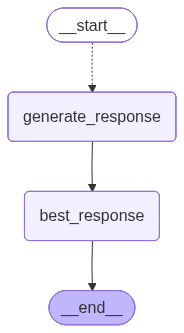

In [7]:
# 创建图
builder = StateGraph(Overall)

# 添加节点
builder.add_node("generate_response", generate_response)
builder.add_node("best_response", best_response)

# 添加边
builder.add_conditional_edges(START, continue_to_responses, ["generate_response"])
builder.add_edge("generate_response", "best_response")
builder.add_edge("best_response", END)

# 编译图
my_graph = builder.compile(name='best-response')
my_graph

In [8]:
# 调用图
roles = ["男神", "暖男", "海王", "痴情男", "决绝的男生", "茶茶的男生 💅💅💅",
         "理想主义的男生", "喜欢唏嘘的男生", "大男子主义的男生", "二次元肥宅"]
response = my_graph.invoke({"roles": roles})

In [9]:
for role, resp in zip(roles, response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【男神】
看来我的消息在你的聊天列表里迷路了，要不要我再发一次？😉

【暖男】
没关系，等你方便的时候再回我就好，希望你今天过得开心～

【海王】
刚在忙，没看到消息～不过你一上线，我的心就自动弹窗提醒了✨

【痴情男】
没关系，等你方便的时候再回我就好，我一直都在。

【决绝的男生】
既然你总是不回消息，那我也不打扰了，祝你一切安好。

【茶茶的男生 💅💅💅】
宝～是在忙吗？茶茶等你回消息等到指甲都重新涂了三遍💅✨

【理想主义的男生】
没关系，我理解你可能在忙；愿你一切安好，等你有空时再聊。

【喜欢唏嘘的男生】
看来我的消息又在你的已读列表里迷路了，不过没关系，我等得起。

【大男子主义的男生】
我尊重你的时间和空间，等你愿意回我时，我依然在这里。

【二次元肥宅】
女神大人今天也在忙着拯救世界吧……我这就默默肝完这期限定池等你回眸！(๑•̀ㅂ•́)و✧



In [10]:
print("最佳回复：", response["best_response"])

最佳回复： 没关系，等你方便的时候再聊，我一直都在～



> **Note**
> 感觉 LangGraph 把并行写复杂了。用 [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) 写一个 tool，也许会更简单。